ในการพัฒนาระบบ AI สำหรับวินิจฉัยโรค ชนิดของข้อมูล Dataset ที่เราจะพบบ่อย ๆ หนึ่งในนั้นคือไฟล์ DICOM ซึ่งเป็นไฟล์สำหรับฟิล์มเ X-Ray, MRI, CT-Scan, Ultrasound ใน ep นี้เราจะมาทำความเข้าใจ ไฟล์ DICOM กันให้มากขึ้น

# DICOM คืออะไร

DICOM ย่อมาจาก Digital Imaging and Communications in Medicine เป็นมาตรฐานกลางในการสื่อสาร จัดเก็บ เรียกดู ประมวลผล จัดพิมพ์ และแสดงผลข้อมูลรูปภาพทางการแพทย์ กำหนดโดย องค์กรชื่อ National Electrical Manufacturers Association (NEMA)

มาตรฐาน DICOM ทำให้เราสามารถใช้ข้อมูลต่าง ๆ ร่วมกันได้ข้ามระบบ ระหว่างอุปกรณ์ต่าง ๆ ตั้งแต่ อุปกรณ์ถ่ายภาพ, PACS (Picture Archiving and Communication System), Workstation, VNAs และเครื่องพิมพ์ จากหลากหลายยี่ห้อ

ภายในไฟล์จะประกอบด้วยทั้งส่วน Header ที่เป็น Metada และส่วนของข้อมูลรูปภาพ ซึ่งมีได้มากกว่า 1 รูปต่อ 1 ไฟล์  เรามาดูตัวอย่างไฟล์ และรูปแบบข้อมูลในไฟล์กันดีกว่า

เช็ค GPU

In [14]:
! nvidia-smi

Wed Jun 10 07:04:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 0. Magic Command

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Install Library

Install Library ที่จำเป็น ในที่นี้เราจะใช้ โมดูล medical.imaging ของ fastai2 

In [0]:
# # Colab
# ! pip install fastai2 -q
# ! pip install pydicom -q
# ! pip install kornia -q

# 2. Import Library

Import Library ที่จำเป็น

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

# 3. Dataset

ในเคสนี้เราจะใช้ Dataset ฟิล์ม X-Ray จาก Kaggle เหมือนใน ep ก่อน [พัฒนาโปรแกรม AI การแพทย์ วินิจฉัยภาวะปอดรั่ว Pneumothorax](https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/)

เราจะ Mount Drive ไปยัง Google Drive ที่เก็บ Token File ไว้

In [18]:
dataset = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

path = data_path_base/dataset

from google.colab import drive

drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*ในการจะ Download ข้อมูลจาก Kaggle ต้องใช้ Token ดูวิธีได้ใน ep ก่อน*

In [0]:
# !kaggle datasets download {dataset} -p "{path}" --unzip

ls ดูว่าได้ Folder อะไรมาบ้าง

In [20]:
path.ls()

(#4) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/train-rle.csv'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-test')]

ดูข้อมูลใน Training Folder

In [21]:
(path/'dicom-images-train').ls()

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4440.1517875182.865104'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2387.1517875172.498320'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3040.1517875175.770006'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4160.1517875181.431435'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.564.1517875163.450860'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.13847.1517875248.270838'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmen

ใช้ฟังก์ชัน `get_dicom_files` ดึงไฟล์ทั้งหมดมาใส่ List ไว้ก่อน

In [22]:
items = get_dicom_files(path/'dicom-images-train')
items

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4440.1517875182.865104/1.2.276.0.7230010.3.1.3.8323329.4440.1517875182.865103/1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2387.1517875172.498320/1.2.276.0.7230010.3.1.3.8323329.2387.1517875172.498319/1.2.276.0.7230010.3.1.4.8323329.2387.1517875172.498321.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3040.1517875175.770006/1.2.276.0.7230010.3.1.3.8323329.3040.1517875175.770005/1.2.276.0.7230010.3.1.4.8323329.3040.1517875175.770007.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4160.1517875181.431435/1.2.276.0.7230010.3.1.3.8323329.41

# 4. DICOM File

เลือกคนไข้ขึ้นมา 1 คน แล้วใช้ฟังก์ชัน `dcmread` เปิดไฟล์ขึ้นมาแสดงผลดูรูปภาพภายใน ไฟล์ DICOM

In [68]:
patient = 5555
items[patient]

Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4167.1517875181.472600/1.2.276.0.7230010.3.1.3.8323329.4167.1517875181.472599/1.2.276.0.7230010.3.1.4.8323329.4167.1517875181.472601.dcm')

## 4.1 Image

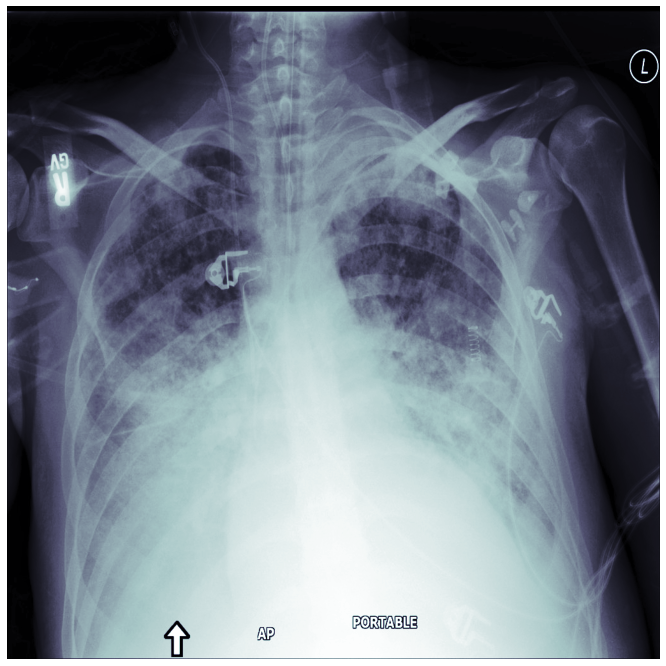

In [23]:
xray_sample = dcmread(items[patient])
xray_sample.show(figsize=(12, 12))

# 4.2 Metadata

ดู Metadata ในไฟล์ DICOM

In [24]:
xray_sample.as_dict()

{'AccessionNumber': '',
 'BitsAllocated': 8,
 'BitsStored': 8,
 'BodyPartExamined': 'CHEST',
 'Columns': 1024,
 'ConversionType': 'WSD',
 'HighBit': 7,
 'InstanceNumber': 1,
 'LossyImageCompression': '01',
 'LossyImageCompressionMethod': 'ISO_10918_1',
 'Modality': 'CR',
 'MultiPixelSpacing': 1,
 'PatientAge': '33',
 'PatientBirthDate': '',
 'PatientID': '716aaca8-0e9e-4f48-88af-9516e79e8103',
 'PatientName': '716aaca8-0e9e-4f48-88af-9516e79e8103',
 'PatientOrientation': '',
 'PatientSex': 'M',
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelRepresentation': 0,
 'PixelSpacing': 0.168,
 'PixelSpacing1': 0.168,
 'ReferringPhysicianName': '',
 'Rows': 1024,
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.7',
 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.4167.1517875181.472601',
 'SamplesPerPixel': 1,
 'SeriesDescription': 'view: AP',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.4167.1517875181.472599',
 'SeriesNumber': 1,
 'SpecificCharacterSet': 'ISO_IR 100',
 'StudyDate': '

จะเห็นว่า มีหลายตัวที่น่าสนใจ เช่น 

* BitsStored เป็นตัวบอกว่ารูปภาพกี่ Bit อาจจะเป็น 8, 14, 16 Bit การแปลงเป็น 8 Bit x 3 Channel RGB เพื่อแสดงผลบนจอภาพ อาจจะทำให้สูญเสียข้อมูลได้
* PixelRepresentation บอกว่าข้อมูลเป็น Signed หรือ Unsigned
* img_max, img_mean, img_min บอกสถิติของข้อมูล Pixel

## 4.3 Pixels Data

ในเคสนี้ ขนาดของรูปภาพคือ 1024 x 1024 Pixel

In [25]:
xray_sample.pixels.shape

torch.Size([1024, 1024])

เป็นรูปภาพขาวดำ Grayscale 0-255

In [26]:
xray_sample.pixels.min(), xray_sample.pixels.max(), xray_sample.scaled_px.min(), xray_sample.scaled_px.max()

(tensor(0.), tensor(255.), tensor(0.), tensor(255.))

In [27]:
xray_sample.pixels[300:310, 400:410]

tensor([[116., 117., 117., 115., 114., 116., 120., 122., 120., 120.],
        [114., 115., 116., 117., 117., 117., 119., 120., 120., 120.],
        [113., 114., 115., 116., 117., 117., 118., 119., 119., 120.],
        [117., 116., 115., 115., 116., 118., 120., 121., 118., 120.],
        [115., 114., 114., 114., 115., 117., 119., 120., 117., 119.],
        [115., 114., 113., 114., 115., 117., 119., 121., 118., 119.],
        [115., 114., 113., 113., 114., 117., 119., 121., 119., 119.],
        [115., 114., 113., 113., 114., 117., 119., 121., 120., 120.],
        [115., 114., 113., 113., 114., 116., 119., 121., 121., 120.],
        [114., 114., 113., 113., 114., 116., 118., 120., 121., 120.]])

In [28]:
xray_sample.scaled_px[300:310, 400:410]

tensor([[116., 117., 117., 115., 114., 116., 120., 122., 120., 120.],
        [114., 115., 116., 117., 117., 117., 119., 120., 120., 120.],
        [113., 114., 115., 116., 117., 117., 118., 119., 119., 120.],
        [117., 116., 115., 115., 116., 118., 120., 121., 118., 120.],
        [115., 114., 114., 114., 115., 117., 119., 120., 117., 119.],
        [115., 114., 113., 114., 115., 117., 119., 121., 118., 119.],
        [115., 114., 113., 113., 114., 117., 119., 121., 119., 119.],
        [115., 114., 113., 113., 114., 117., 119., 121., 120., 120.],
        [115., 114., 113., 113., 114., 116., 119., 121., 121., 120.],
        [114., 114., 113., 113., 114., 116., 118., 120., 121., 120.]])

## 4.4 Histogram

ลองพล็อต Histogram จะเห็นว่า ข้อมูลมีบางระดับที่มากน้อยต่างกัน บางค่าก็น้อยมาก

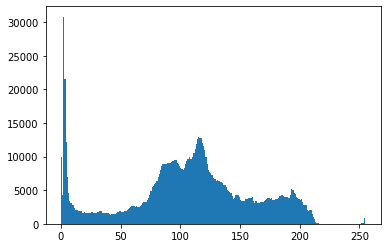

In [80]:
hist = plt.hist(xray_sample.pixels.reshape(-1).numpy(), bins=255)

## 4.5 Normalize

เราสามารถแบ่งข้อมูลออกเป็น Bins ตามความถี่ให้ข้อมูลกระจายออกไปทั่ว ๆ เป็นการ Normalize

In [85]:
bins = xray_sample.pixels.freqhist_bins()
bins.shape, bins

(torch.Size([95]),
 tensor([  0.,   2.,   3.,   4.,   6.,   9.,  14.,  20.,  26.,  32.,  39.,  46.,
          52.,  57.,  61.,  65.,  69.,  72.,  75.,  77.,  78.,  80.,  82.,  83.,
          84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  94.,  95.,  96.,  97.,
          98.,  99., 101., 102., 103., 104., 106., 107., 108., 109., 110., 111.,
         112., 113., 114., 115., 116., 117., 118., 119., 120., 122., 123., 124.,
         125., 127., 128., 130., 132., 133., 135., 137., 139., 141., 143., 146.,
         148., 151., 154., 157., 160., 163., 166., 169., 172., 175., 178., 181.,
         184., 186., 189., 191., 194., 196., 198., 201., 205., 210., 252.]))

แสดง Histogram อีกครั้ง จาก Bins ด้านบน จะเห็นว่ากระจายดีขึ้น โมเดลจะได้ทำงานง่ายขึ้น

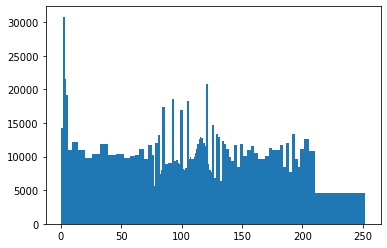

In [83]:
hist = plt.hist(xray_sample.pixels.reshape(-1).numpy(), bins=bins)

## 4.6 DICOM Windows

ในการวิเคราะห์ วินิจฉัยโรค โดยแพทย์ผู้ชำนาญการ เนื่องจากสายตาของมนุษย์ โดยทั่วไปสามารถแยกแยะได้แค่ประมาณ 100 ระดับสีเท่านั้น ในการแสดงผล จึงมีการแยกเฉพาะ Window ในช่วงข้อมูลต่าง ๆ มาแสดงผล ตามความหนาแน่นทางรังสี Radiodensity ตามช่วง Hounsfield scale ของอวัยวะที่เราสนใจ

In [30]:
dicom_windows

namespace(abdomen_soft=(400, 50), brain=(80, 40), brain_bone=(2800, 600), brain_soft=(375, 40), liver=(150, 30), lungs=(1500, -600), mediastinum=(350, 50), spine_bone=(1800, 400), spine_soft=(250, 50), stroke=(8, 32), subdural=(254, 100))

ดูว่าข้อมูล Pixel ทั้งหมดใ อยู่ใน Window ที่กำหนดกี่เปอร์เซ็นต์

In [0]:
# xray_sample.pct_in_window??

In [32]:
xray_sample.pct_in_window(*dicom_windows.brain)

0.24142742156982422

In [33]:
xray_sample.pct_in_window(*dicom_windows.lungs)

0.789179801940918

In [34]:
xray_sample.pct_in_window(*dicom_windows.mediastinum)

0.9984903335571289

เราสามารถ เอา Window มา Mask เอาเฉพาะส่วนที่เราสนใจได้

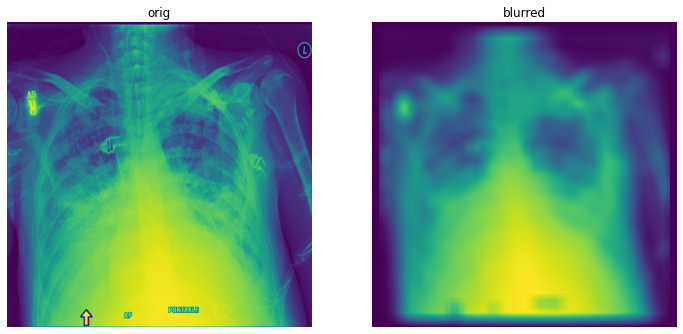

In [35]:
ims = xray_sample.hist_scaled(), uniform_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

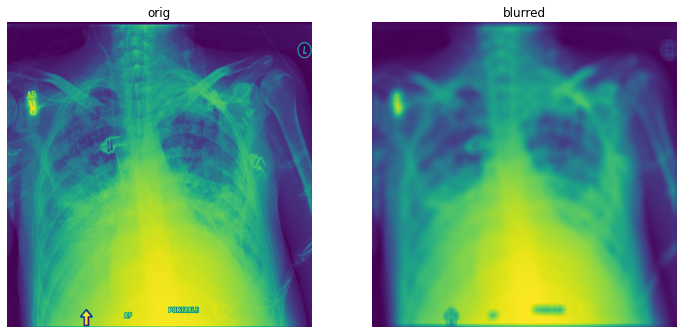

In [36]:
ims = xray_sample.hist_scaled(), gauss_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

In [0]:
# xray_sample.mask_from_blur??

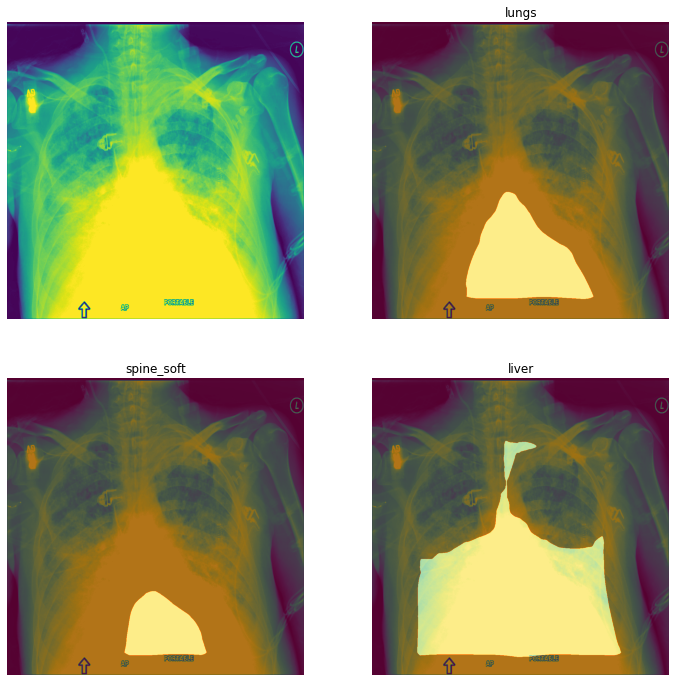

In [38]:
wind = xray_sample.windowed(*dicom_windows.lungs)
mask1 = xray_sample.mask_from_blur(dicom_windows.lungs)
mask2 = xray_sample.mask_from_blur(dicom_windows.spine_soft)
mask3 = xray_sample.mask_from_blur(dicom_windows.liver)

_,ax = subplots(2,2, figsize=(12, 12))
ax = ax.reshape(-1)
show_image(wind, ax=ax[0])
show_image(wind, ax=ax[1])
show_image(wind, ax=ax[2])
show_image(wind, ax=ax[3])

show_image(mask1, alpha=0.5, cmap=plt.cm.Reds, ax=ax[1], title="lungs");
show_image(mask2, alpha=0.5, cmap=plt.cm.Reds, ax=ax[2], title="spine_soft");
show_image(mask3, alpha=0.5, cmap=plt.cm.Reds, ax=ax[3], title="liver");

แต่ดวงตาของมนุษย์ และการแสดงผลบนจอภาพแบบขาวดำ ยังไงก็มีข้อจำกัด มีแนวคิดที่จะใช้การแสดงผลแบบสี RGB เข้ามาช่วยให้เหมาะกับการแสดงผลของจอภาพ และอำนวยความสะดวกกับดวงตามนุษย์มากขึ้น

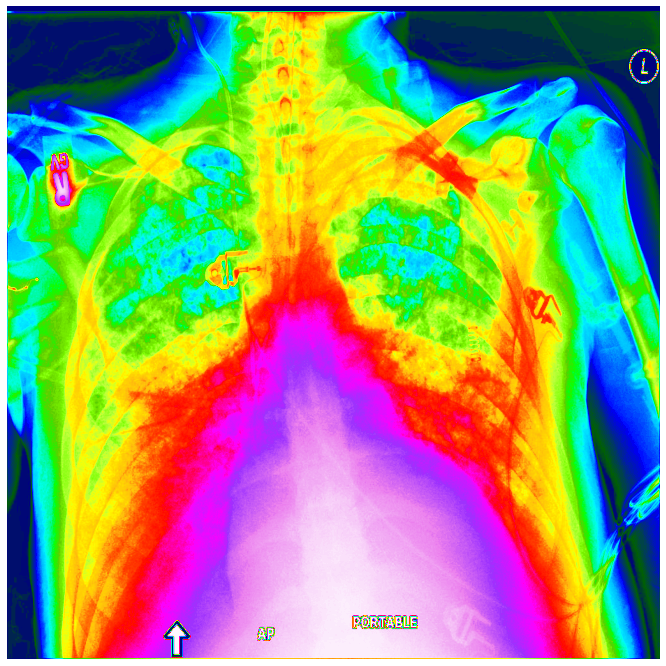

In [39]:
xray_sample.show(cmap=plt.cm.gist_ncar, figsize=(12, 12))

## 4.7 Bounding Box

เราสามารถสร้าง Bounding Box จาก Mask ได้

In [99]:
mask = xray_sample.mask_from_blur(dicom_windows.stroke)
bbs = mask2bbox(mask)
bbs

tensor([[ 626,  953],
        [ 797, 1023]], device='cuda:0')

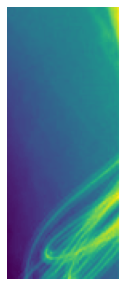

In [102]:
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]], figsize=(5, 5));

# 5. Data Pipeline

## 5.1 Data Preparation

ดูไฟล์ที่เก็บ Label 

In [42]:
df = pd.read_csv(path/'train-rle.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992...
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 992 32 992 32 991 33 991 33 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 989 35 989 36 988 36 988 16 1 19 988 15 3 18 988 15 4 16 989 14 8 13 989 14 8 13 989 13 9 13 989 13 9 13 989 12 10 13 989 12 10 13 989 11 11 13 989 11 11 13 989 11 11 13 989 10 11 14 989 10 11 14 990 9 9 16 990 9 7 18 990 9 6 18 991 9 6 18 991 9 5 19 992 8 4 20 992 7 5 20 993 6 4 21 993 6 4 21 994 4 4 22 995 3 5 20 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 1004 19 1004 18 1004 19 1004 19 1002 21 1001 22 1001 22 1000 23 1000 23 999 24 997 26 997 25 997 26 997 26 997 26 996 27 996 27 996 27 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 28 995 28 995 28 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 30 993 30 993 30 994 29 994 28 995 28 995 28 994 30 993 30 993 30 994 29 994 30 993 30 993 30 994 30 993 30 993 30 993 31 992 31 992 32 991 32 9...


Dataset นี้เป็นงาน Segmentation ใน Column EncodedPixels จะมีระบุว่า Pixel ไหนบ้างที่เป็นส่วนของ Pneumothorax ถ้าไม่ป่วยจะเป็น -1 

เราจะแปลงให้เป็นงาน Classification ด้วยการสร้าง Column ใหม่

มีข้อมูลบางส่วน Duplicate เราจะ Remove ออกไป

In [0]:
# sorting by first name 
df.sort_values("ImageId", inplace = True) 
  
# dropping ALL duplicte values 
df.drop_duplicates(subset ="ImageId", 
                     keep = 'first', inplace = True) 
  

ไม่ใช่ -1 แต่เป็น ' -1' มี space อยู่ด้านหน้าด้วย

In [44]:
df.iloc[1, 1]

' -1'

สร้าง Column ใหม่ จากเงื่อนไข -1 = Normal ถ้าไม่ใช่แสดงว่าป่วยเป็น Pneumothorax

In [45]:
df.loc[df.iloc[:, 1] == ' -1', 'label'] = "Normal"
df.loc[df.iloc[:, 1] != ' -1', 'label'] = "Pneumothorax"

df.sample(5)

,ImageId,EncodedPixels,label
4025,1.2.276.0.7230010.3.1.4.8323329.13842.1517875248.230485,-1,Normal
367,1.2.276.0.7230010.3.1.4.8323329.13719.1517875247.372338,625797 1 1023 1 1023 1 1023 2 1022 2 1021 3 1021 3 1021 3 1021 3 1021 3 1021 3 1021 3 1021 3 1021 3 1021 3 1020 4 1020 4 1020 4 1020 5 1019 5 1018 6 1018 6 1018 6 1018 7 1017 7 1017 7 1017 7 1017 7 1017 8 1016 8 1015 9 1015 9 1015 9 1015 10 1014 10 1013 11 1013 11 1013 12 1012 12 1012 12 1012 12 1012 12 1012 13 1011 13 1011 13 1010 14 1010 14 1010 15 1009 15 1009 15 1008 16 1008 16 1008 17 1007 17 1007 17 1007 17 1007 17 1007 18 1006 18 1005 19 1005 19 1005 19 1005 20 1004 20 1003 21 1003 21 1004 20 1004 21 1003 21 1003 21 1003 21 1004 20 1004 21 1003 21 1003 21 1003 21 1004 20 1004 21 10...,Pneumothorax
9613,1.2.276.0.7230010.3.1.4.8323329.12806.1517875241.951371,-1,Normal
2740,1.2.276.0.7230010.3.1.4.8323329.32254.1517875159.256888,182498 3 1018 7 1014 10 1010 15 1007 17 1005 20 1001 23 998 26 993 31 989 35 986 38 983 41 980 44 977 47 975 49 972 51 971 53 969 54 968 45 1 8 968 45 978 44 978 43 979 43 979 43 979 43 979 42 980 42 981 41 981 41 981 41 981 42 981 41 981 41 982 40 983 38 984 38 985 38 983 39 983 40 983 40 982 40 983 40 983 40 982 40 983 40 983 40 982 41 982 41 982 41 981 42 981 42 981 42 980 43 980 44 979 44 978 45 978 45 978 46 978 45 978 45 978 45 978 46 976 47 976 47 976 48 975 48 975 49 974 50 973 50 973 50 973 51 972 51 972 51 972 52 971 52 971 53 971 52 971 53 970 53 970 54 969 55 968 55 968 56 968...,Pneumothorax
1163,1.2.276.0.7230010.3.1.4.8323329.2867.1517875175.139204,568542 29 992 37 941 2 36 51 932 8 30 44 941 82 941 82 942 81 942 80 943 76 947 73 951 71 952 70 953 70 953 69 955 67 956 67 956 67 957 66 957 66 957 66 958 65 958 64 959 64 960 63 961 62 962 61 963 60 964 59 965 58 966 57 968 55 969 54 970 53 971 52 972 51 973 50 975 49 975 48 976 48 976 48 976 47 977 47 978 45 979 45 980 43 981 43 981 42 983 41 983 40 984 40 985 39 985 38 986 38 987 37 987 37 988 35 989 35 990 34 990 35 989 35 990 34 990 34 990 34 991 33 991 34 990 34 991 33 991 33 991 33 991 34 991 33 991 33 991 33 992 32 993 32 992 32 993 31 993 31 994 31 994 30 995 29 996 29 995 29 9...,Pneumothorax


Drop Column ที่ไม่เกี่ยวข้องทิ้งไป

In [46]:
df = df.drop(df.columns[[1]], axis=1)
df.head()

,ImageId,label
5667,1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027,Normal
8268,1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530,Normal
8707,1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580,Normal
11189,1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397,Normal
8802,1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420,Normal


## 5.2 Exploratory Data Analysis (EDA)

In [47]:
df['label'].value_counts()

Normal          8296
Pneumothorax    2379
Name: label, dtype: int64

In [48]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312']

,ImageId,label
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,Pneumothorax


In [49]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312'].label.values[0]

'Pneumothorax'

In [50]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530'].label.values[0]

'Normal'

## 5.3 DataBlock

มีบางอันไม่ Match ให้ Default เป็น Normal

In [0]:
def label_func(fn):        
    lbl = df[df['ImageId'] == fn.stem].label.to_numpy()
    if len(lbl) == 0 : return "Normal"
    return lbl[0]

สร้าง DataBlock และ DataLoader

In [0]:
def getDataLoaders(bs, size):
    pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock), 
                         get_items=get_dicom_files, 
                         get_y=label_func, 
                         batch_tfms=[*aug_transforms(size=size)]
                         )
    # pneumothorax.summary(path/'dicom-images-train')
    dls = pneumothorax.dataloaders(path/'dicom-images-train', bs=bs)
    return dls    

สร้าง DataLoader ด้วย size 224 และ Batch Size 64 แล้วแสดงข้อมูลตัวอย่าง ใน Batch 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


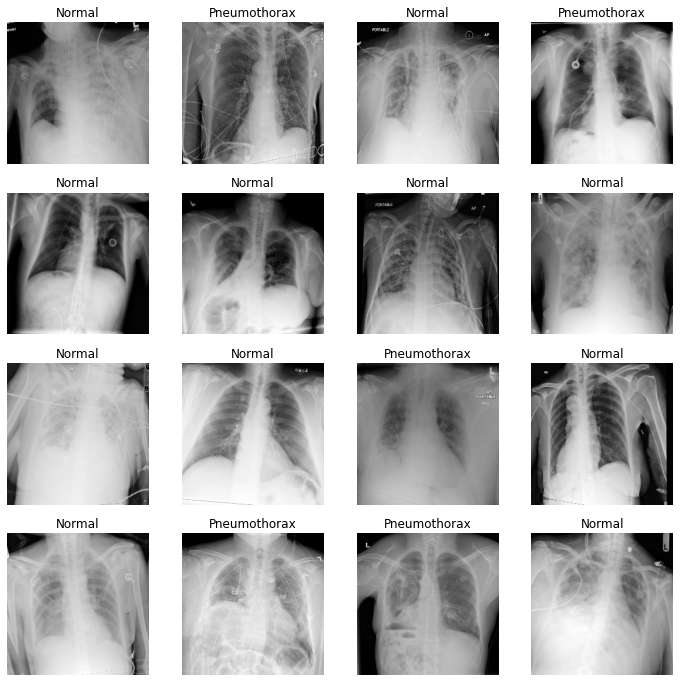

In [53]:
dls = getDataLoaders(64, 224)
dls.show_batch(max_n=16)

เช็คว่ามี 2 Class

In [54]:
dls.vocab

(#2) ['Normal','Pneumothorax']

# 6. Model

เพื่อความง่าย เราจะใช้ resnet34 ธรรมดาเท่านั้น

In [55]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    cbs=[ShowGraphCallback])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


# 7. Train

## 7.1 Fine-tune

เริ่มต้นเทรนเรียก Fine-Tune ให้เทรน 2 Step

epoch,train_loss,valid_loss,accuracy,time
0,0.787449,0.559908,0.739496,02:00


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


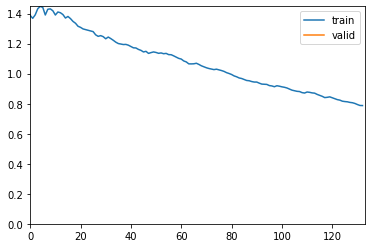

epoch,train_loss,valid_loss,accuracy,time
0,0.507384,0.418113,0.807190,02:01
1,0.430251,0.363536,0.838002,02:01
2,0.367866,0.336327,0.847339,02:02
3,0.326441,0.321735,0.855275,02:01
4,0.287644,0.315507,0.859944,02:00
5,0.258522,0.309738,0.865079,02:01


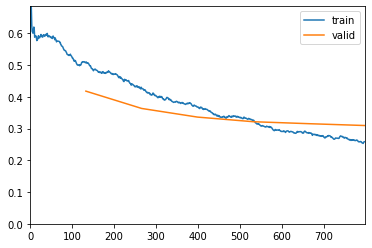

In [56]:
learn.fine_tune(6)

ได้ Accuracy 86.5% เซฟโมเดลไว้ก่อน

In [0]:
learn.save("224")

## 7.2 Progressive Resizing

สร้าง Data Loader ใหม่ด้วย size รูป 320 x 320 Pixel และ ลดขนาด Batch Size เหลือ 32

In [58]:
dls = getDataLoaders(32, 320)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


สร้าง Learner ใหม่จาก Data Loader ด้านบน

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    cbs=[ShowGraphCallback])

โหลดโมเดล 224 ขึ้นมา

In [60]:
learn.load("224")

เทรนต่อ

epoch,train_loss,valid_loss,accuracy,time
0,0.335750,0.291509,0.870682,02:07


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


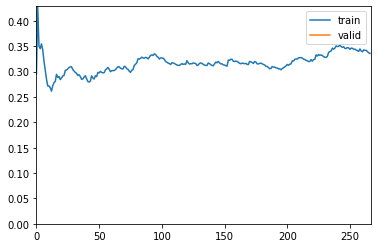

epoch,train_loss,valid_loss,accuracy,time
0,0.327187,0.300754,0.867414,02:11
1,0.312079,0.391431,0.838002,02:10
2,0.310298,0.330213,0.854342,02:10
3,0.267336,0.283537,0.874416,02:11
4,0.211717,0.301884,0.879552,02:12
5,0.168705,0.306836,0.881419,02:12


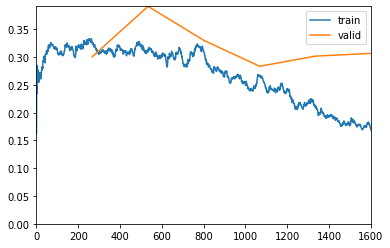

In [61]:
learn.fine_tune(6)

ได้ Accuracy 88.1% 

In [0]:
learn.save("320")

แสดงผลลัพธ์การทำงาน

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


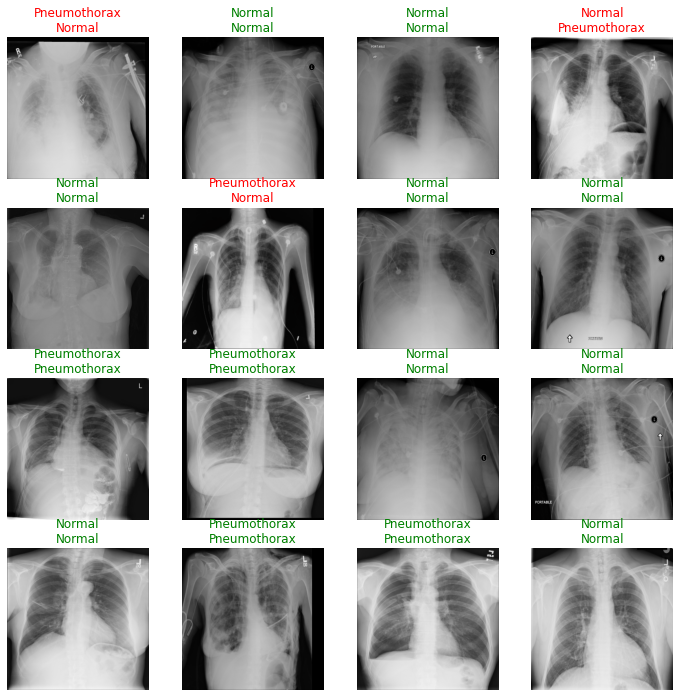

In [63]:
learn.show_results(max_n=16)

# 8. ตีความผลลัพธ์

เราจะใช้ คลาส ClassificationInterpretation ในการช่วยตีความผลการทำงานของโมเดล

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


พล็อต Confusion Matrix

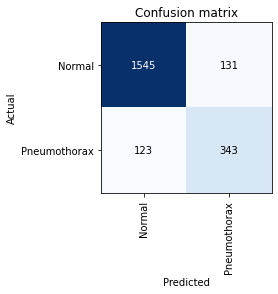

In [65]:
interp.plot_confusion_matrix()

แสดงสถิติที่เกี่ยวข้อง

In [66]:
interp.print_classification_report()

              precision    recall  f1-score   support

      Normal       0.93      0.92      0.92      1676
Pneumothorax       0.72      0.74      0.73       466

    accuracy                           0.88      2142
   macro avg       0.82      0.83      0.83      2142
weighted avg       0.88      0.88      0.88      2142



แสดงรายการที่โมเดลทางผิดมากที่สุด

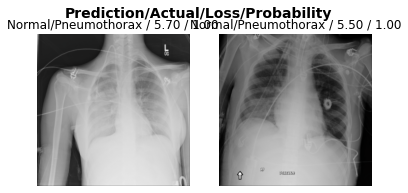

In [67]:
interp.plot_top_losses(2)

# Credit

* https://dev.fast.ai/medical.imaging
* https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai
* https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://github.com/fastai/fastai2/blob/master/nbs/61_tutorial.medical_imaging.ipynb
* https://en.wikipedia.org/wiki/Hounsfield_scale